<a href="https://colab.research.google.com/github/nimra7a/Computer-Vision-Projects/blob/main/AlphaGAN_AlzheimerMRI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 🧠 Alpha-GAN for Alzheimer MRI Anomaly Detection

This notebook implements a **3D Alpha-GAN** model (based on [Alpha-GAN: Generative Adversarial Networks for Natural Image Matting](https://arxiv.org/pdf/1908.02498v1)) to generate and analyze **Alzheimer MRI scans** using a combination of **VAE**, **WGAN-GP**, and **Code Discriminator** components. The goal is anomaly detection and synthetic data generation.

**Dataset**: [Alzheimer MRI Disease Classification (Kaggle)](https://www.kaggle.com/datasets/borhanitrash/alzheimer-mri-disease-classification-dataset)


In [ ]:
# Upload kaggle.json from your local machine
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"zainubnoor","key":"000a8c627b5eb91c0d6d4152d807347b"}'}

In [ ]:
# Move kaggle.json to the correct location
import os
import zipfile

os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json


In [ ]:
# Download the dataset using the Kaggle API
!kaggle datasets download -d abdullahtauseef2003/adni-4c-alzheimers-mri-classification-dataset

Dataset URL: https://www.kaggle.com/datasets/abdullahtauseef2003/adni-4c-alzheimers-mri-classification-dataset
License(s): CC0-1.0


In [ ]:
# Unzip the downloaded dataset
!unzip -q adni-4c-alzheimers-mri-classification-dataset.zip -d ./alz_data

In [ ]:
import os

# Explore the folder structure
base_path = './alz_data'
for root, dirs, files in os.walk(base_path):
    print(f"Directory: {root}")
    for d in dirs:
        print(f"  Subdirectory: {d}")
    for f in files[:5]:  # Print up to 5 files
        print(f"  File: {f}")
    break  # Only show the top level for now


Directory: ./alz_data
  Subdirectory: AugmentedAlzheimerDataset


In [ ]:
# Drill into AugmentedAlzheimerDataset
aug_path = './alz_data/AugmentedAlzheimerDataset'

for root, dirs, files in os.walk(aug_path):
    print(f"Directory: {root}")
    for d in dirs:
        print(f"  Subdirectory: {d}")
    for f in files[:5]:
        print(f"  File: {f}")
    break


Directory: ./alz_data/AugmentedAlzheimerDataset
  Subdirectory: LMCI
  Subdirectory: .tmp.driveupload
  Subdirectory: AD
  Subdirectory: CN
  Subdirectory: EMCI


In [ ]:
import tensorflow as tf

img_size = 224
batch_size = 32

dataset_dir = './alz_data/AugmentedAlzheimerDataset'

# Load training dataset with validation split
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    labels="inferred",
    label_mode="categorical",
    color_mode="grayscale",
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(img_size, img_size),
    batch_size=batch_size,
    shuffle=True
)

# Load validation dataset from same folder
val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    labels="inferred",
    label_mode="categorical",
    color_mode="grayscale",
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(img_size, img_size),
    batch_size=batch_size,
    shuffle=True
)


Found 33984 files belonging to 4 classes.
Using 27188 files for training.
Found 33984 files belonging to 4 classes.
Using 6796 files for validation.


In [ ]:
from tensorflow.keras.applications.efficientnet import preprocess_input

# Preprocess pipeline
def preprocess_pipeline(image, label):
    image = tf.image.grayscale_to_rgb(image)  # (224, 224, 1) → (224, 224, 3)
    image = preprocess_input(image)           # EfficientNet normalization
    return image, label

# Apply the pipeline to both sets
train_ds = train_ds.map(preprocess_pipeline)
val_ds = val_ds.map(preprocess_pipeline)


In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, Model

# Load EfficientNetB0 base (exclude top layer)
base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(img_size, img_size, 3)
)
base_model.trainable = False  # Freeze the base

# Build the full model
inputs = layers.Input(shape=(img_size, img_size, 3))
x = base_model(inputs)

# Custom CNN layers
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.BatchNormalization()(x)

# Fully connected layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.4)(x)
x = layers.BatchNormalization()(x)

# Final classification layer (4 classes: AD, CN, EMCI, LMCI)
outputs = layers.Dense(4, activation='softmax')(x)

# Compile the model
model = Model(inputs=inputs, outputs=outputs, name="EfficientNet_Alzheimer")

model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "EfficientNet_Alzheimer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 7, 7, 64)       │       737,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 3, 3, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 3, 3, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1, 1, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       132,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,707,047 (21.77 MB)

 Trainable params: 1,656,068 (6.32 MB)

 Non-trainable params: 4,050,979 (15.45 MB)

In [ ]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam

# Learning rate schedule
lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=1000,
    decay_rate=0.9
)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=lr_schedule),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Callbacks
checkpoint_cb = ModelCheckpoint(
    "best_model.h5",
    save_best_only=True,
    monitor="val_accuracy",
    mode="max",
    verbose=1
)

earlystop_cb = EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    callbacks=[checkpoint_cb, earlystop_cb]
)


Epoch 1/25
850/850 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.5102 - loss: 1.1624
Epoch 1: val_accuracy improved from -inf to 0.68011, saving model to best_model.h5


850/850 ━━━━━━━━━━━━━━━━━━━━ 100s 83ms/step - accuracy: 0.5104 - loss: 1.1621 - val_accuracy: 0.6801 - val_loss: 0.7002
Epoch 2/25
849/850 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7249 - loss: 0.6266
Epoch 2: val_accuracy improved from 0.68011 to 0.77251, saving model to best_model.h5


850/850 ━━━━━━━━━━━━━━━━━━━━ 102s 55ms/step - accuracy: 0.7250 - loss: 0.6265 - val_accuracy: 0.7725 - val_loss: 0.5216
Epoch 3/25
849/850 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7997 - loss: 0.4818
Epoch 3: val_accuracy improved from 0.77251 to 0.78075, saving model to best_model.h5


850/850 ━━━━━━━━━━━━━━━━━━━━ 82s 55ms/step - accuracy: 0.7997 - loss: 0.4818 - val_accuracy: 0.7808 - val_loss: 0.5450
Epoch 4/25
850/850 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8419 - loss: 0.3879
Epoch 4: val_accuracy improved from 0.78075 to 0.87699, saving model to best_model.h5


850/850 ━━━━━━━━━━━━━━━━━━━━ 82s 55ms/step - accuracy: 0.8419 - loss: 0.3878 - val_accuracy: 0.8770 - val_loss: 0.2919
Epoch 5/25
849/850 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8728 - loss: 0.3228
Epoch 5: val_accuracy did not improve from 0.87699
850/850 ━━━━━━━━━━━━━━━━━━━━ 82s 56ms/step - accuracy: 0.8728 - loss: 0.3228 - val_accuracy: 0.8570 - val_loss: 0.3605
Epoch 6/25
849/850 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9016 - loss: 0.2540
Epoch 6: val_accuracy improved from 0.87699 to 0.91539, saving model to best_model.h5


850/850 ━━━━━━━━━━━━━━━━━━━━ 48s 56ms/step - accuracy: 0.9016 - loss: 0.2540 - val_accuracy: 0.9154 - val_loss: 0.2174
Epoch 7/25
850/850 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9193 - loss: 0.2133
Epoch 7: val_accuracy did not improve from 0.91539
850/850 ━━━━━━━━━━━━━━━━━━━━ 47s 56ms/step - accuracy: 0.9193 - loss: 0.2133 - val_accuracy: 0.8877 - val_loss: 0.2887
Epoch 8/25
850/850 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9313 - loss: 0.1824
Epoch 8: val_accuracy improved from 0.91539 to 0.93467, saving model to best_model.h5


850/850 ━━━━━━━━━━━━━━━━━━━━ 48s 56ms/step - accuracy: 0.9314 - loss: 0.1824 - val_accuracy: 0.9347 - val_loss: 0.1748
Epoch 9/25
849/850 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9436 - loss: 0.1499
Epoch 9: val_accuracy did not improve from 0.93467
850/850 ━━━━━━━━━━━━━━━━━━━━ 79s 53ms/step - accuracy: 0.9436 - loss: 0.1499 - val_accuracy: 0.9310 - val_loss: 0.1743
Epoch 10/25
849/850 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9511 - loss: 0.1329
Epoch 10: val_accuracy improved from 0.93467 to 0.94335, saving model to best_model.h5


850/850 ━━━━━━━━━━━━━━━━━━━━ 85s 57ms/step - accuracy: 0.9511 - loss: 0.1329 - val_accuracy: 0.9433 - val_loss: 0.1431
Epoch 11/25
850/850 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9592 - loss: 0.1087
Epoch 11: val_accuracy improved from 0.94335 to 0.96012, saving model to best_model.h5


850/850 ━━━━━━━━━━━━━━━━━━━━ 80s 54ms/step - accuracy: 0.9592 - loss: 0.1087 - val_accuracy: 0.9601 - val_loss: 0.1089
Epoch 12/25
849/850 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9669 - loss: 0.0910
Epoch 12: val_accuracy did not improve from 0.96012
850/850 ━━━━━━━━━━━━━━━━━━━━ 47s 55ms/step - accuracy: 0.9669 - loss: 0.0910 - val_accuracy: 0.9591 - val_loss: 0.1119
Epoch 13/25
850/850 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9714 - loss: 0.0867
Epoch 13: val_accuracy improved from 0.96012 to 0.96130, saving model to best_model.h5


850/850 ━━━━━━━━━━━━━━━━━━━━ 45s 53ms/step - accuracy: 0.9714 - loss: 0.0867 - val_accuracy: 0.9613 - val_loss: 0.1079
Epoch 14/25
849/850 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9740 - loss: 0.0700
Epoch 14: val_accuracy did not improve from 0.96130
850/850 ━━━━━━━━━━━━━━━━━━━━ 47s 55ms/step - accuracy: 0.9740 - loss: 0.0700 - val_accuracy: 0.9481 - val_loss: 0.1613
Epoch 15/25
850/850 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9768 - loss: 0.0655
Epoch 15: val_accuracy did not improve from 0.96130
850/850 ━━━━━━━━━━━━━━━━━━━━ 79s 52ms/step - accuracy: 0.9768 - loss: 0.0655 - val_accuracy: 0.9425 - val_loss: 0.1795
Epoch 16/25
850/850 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9791 - loss: 0.0618
Epoch 16: val_accuracy did not improve from 0.96130
850/850 ━━━━━━━━━━━━━━━━━━━━ 45s 52ms/step - accuracy: 0.9791 - loss: 0.0618 - val_accuracy: 0.9501 - val_loss: 0.1383
Epoch 17/25
850/850 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9824 - loss: 0.0498
Epoch 17: val_ac

850/850 ━━━━━━━━━━━━━━━━━━━━ 82s 53ms/step - accuracy: 0.9824 - loss: 0.0498 - val_accuracy: 0.9694 - val_loss: 0.0883
Epoch 18/25
850/850 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9825 - loss: 0.0476
Epoch 18: val_accuracy did not improve from 0.96939
850/850 ━━━━━━━━━━━━━━━━━━━━ 84s 55ms/step - accuracy: 0.9825 - loss: 0.0476 - val_accuracy: 0.9690 - val_loss: 0.0860
Epoch 19/25
850/850 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9850 - loss: 0.0432
Epoch 19: val_accuracy did not improve from 0.96939
850/850 ━━━━━━━━━━━━━━━━━━━━ 44s 51ms/step - accuracy: 0.9850 - loss: 0.0432 - val_accuracy: 0.9694 - val_loss: 0.0889
Epoch 20/25
849/850 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9877 - loss: 0.0366
Epoch 20: val_accuracy improved from 0.96939 to 0.97175, saving model to best_model.h5


850/850 ━━━━━━━━━━━━━━━━━━━━ 45s 53ms/step - accuracy: 0.9877 - loss: 0.0366 - val_accuracy: 0.9717 - val_loss: 0.0902
Epoch 21/25
850/850 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9895 - loss: 0.0322
Epoch 21: val_accuracy did not improve from 0.97175
850/850 ━━━━━━━━━━━━━━━━━━━━ 44s 52ms/step - accuracy: 0.9895 - loss: 0.0322 - val_accuracy: 0.9700 - val_loss: 0.0916
Epoch 22/25
850/850 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9885 - loss: 0.0350
Epoch 22: val_accuracy did not improve from 0.97175
850/850 ━━━━━━━━━━━━━━━━━━━━ 82s 52ms/step - accuracy: 0.9885 - loss: 0.0350 - val_accuracy: 0.9709 - val_loss: 0.0894
Epoch 23/25
850/850 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9898 - loss: 0.0300
Epoch 23: val_accuracy improved from 0.97175 to 0.97616, saving model to best_model.h5


850/850 ━━━━━━━━━━━━━━━━━━━━ 82s 52ms/step - accuracy: 0.9898 - loss: 0.0300 - val_accuracy: 0.9762 - val_loss: 0.0767
Epoch 24/25
849/850 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9902 - loss: 0.0292
Epoch 24: val_accuracy did not improve from 0.97616
850/850 ━━━━━━━━━━━━━━━━━━━━ 82s 52ms/step - accuracy: 0.9902 - loss: 0.0292 - val_accuracy: 0.9666 - val_loss: 0.1006
Epoch 25/25
850/850 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9910 - loss: 0.0260
Epoch 25: val_accuracy did not improve from 0.97616
850/850 ━━━━━━━━━━━━━━━━━━━━ 46s 54ms/step - accuracy: 0.9910 - loss: 0.0260 - val_accuracy: 0.9726 - val_loss: 0.0836
Restoring model weights from the end of the best epoch: 23.


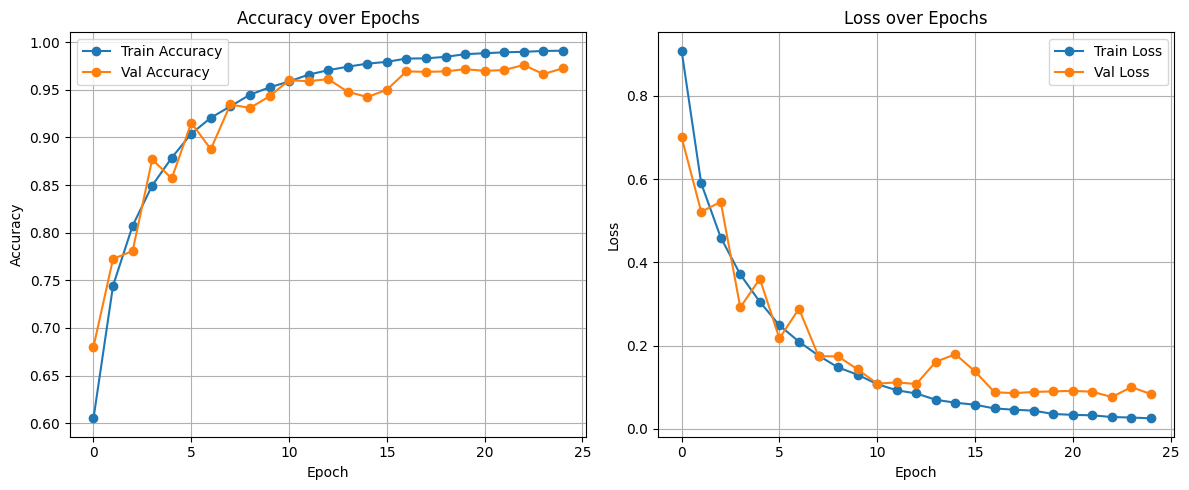

In [ ]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# Define dataset path explicitly
dataset_path = "./alz_data/AugmentedAlzheimerDataset"

# Load the training and validation datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=42,
    label_mode="categorical",
    image_size=(img_size, img_size),
    batch_size=32,
    color_mode="grayscale"
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=42,
    label_mode="categorical",
    image_size=(img_size, img_size),
    batch_size=32,
    color_mode="grayscale"
)

# ✅ Save class names before preprocessing
class_names = train_ds.class_names

# Apply preprocessing
train_ds = train_ds.map(preprocess_pipeline)
val_ds = val_ds.map(preprocess_pipeline)


Found 33984 files belonging to 4 classes.
Using 27188 files for training.
Found 33984 files belonging to 4 classes.
Using 6796 files for validation.


In [ ]:
# 1. Get all predictions and true labels from val_ds
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(tf.argmax(labels, axis=1).numpy())
    y_pred.extend(tf.argmax(preds, axis=1).numpy())

# 2. Define class names (you can modify if you know the order)
class_names = ['AD', 'CN', 'EMCI', 'LMCI']  # Example: replace with your actual class order

# 3. Now print classification report
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=class_names))


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━

In [ ]:
# Save as HDF5 format
model.save("alzheimers_classifier_model.h5")
print("Model saved as alzheimers_classifier_model.h5")

Model saved as alzheimers_classifier_model.h5


In [ ]:
!pip install lime --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import numpy as np
import tensorflow as tf
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt


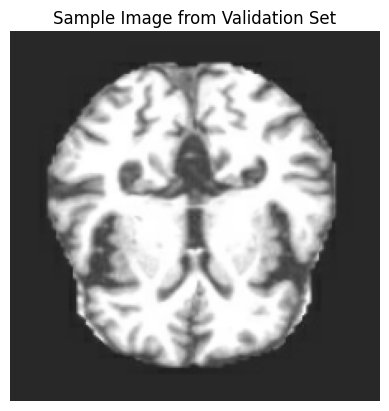

In [ ]:
# Take one batch from the validation set
for images, labels in val_ds.take(1):
    sample_image = images[0].numpy()
    sample_label = labels[0].numpy()
    break

# Display the original image
plt.imshow(sample_image.astype("uint8"))
plt.title("Sample Image from Validation Set")
plt.axis("off")
plt.show()


In [ ]:
from tensorflow.keras.applications.efficientnet import preprocess_input

# Define prediction function expected by LIME
def predict_fn(images):
    images = tf.image.resize(images, (224, 224))  # Resize just in case
    images = preprocess_input(images)             # EfficientNet preprocessing
    preds = model.predict(images)
    return preds


In [ ]:
# Initialize the LIME image explainer
explainer = lime_image.LimeImageExplainer()

# Explain the prediction on the sample image
explanation = explainer.explain_instance(
    image=sample_image.astype('double'),
    classifier_fn=predict_fn,
    top_labels=1,
    hide_color=0,
    num_samples=1000  # Higher = more accurate but slower
)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━

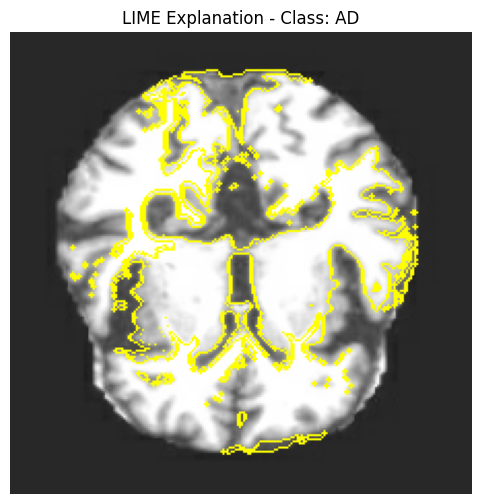

In [ ]:
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

# Get image and mask for the top predicted label
temp, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=True,
    num_features=10,
    hide_rest=False
)

# Plot the explanation
plt.figure(figsize=(6, 6))
plt.title(f"LIME Explanation - Class: {class_names[explanation.top_labels[0]]}")
plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.axis('off')
plt.show()


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━

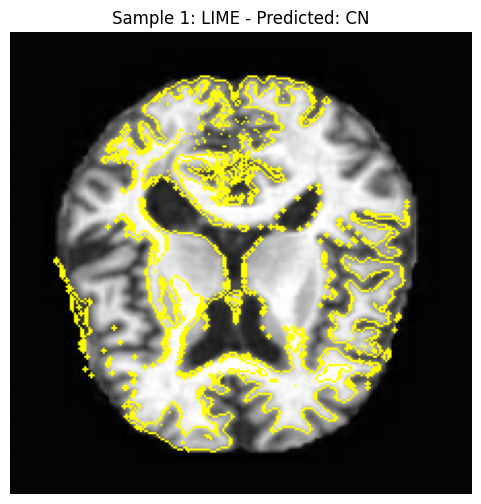

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━

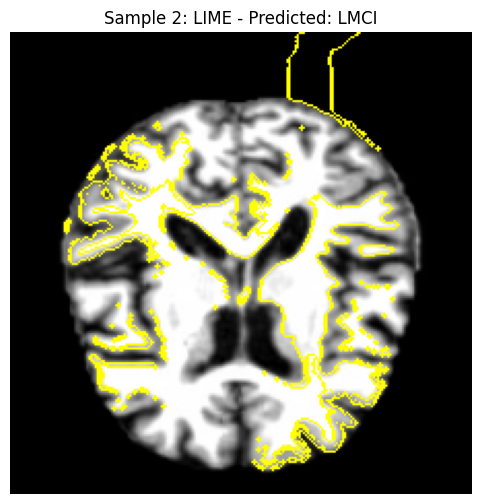

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━

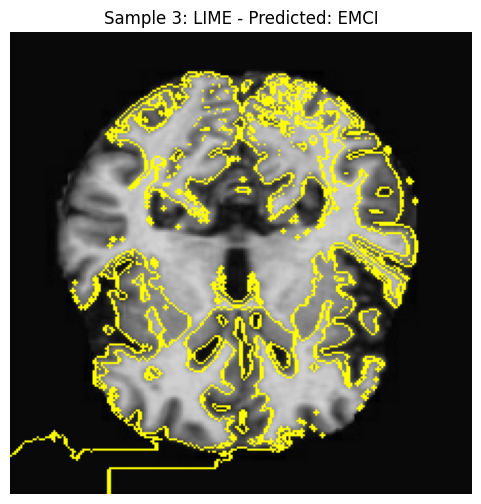

In [ ]:
num_images = 3  # Number of samples you want to visualize
count = 0

for image_batch, label_batch in val_ds.unbatch().take(num_images):
    image = image_batch.numpy()
    label = label_batch.numpy()

    # Explain instance
    explanation = explainer.explain_instance(
        image=image.astype('double'),
        classifier_fn=predict_fn,
        top_labels=1,
        hide_color=0,
        num_samples=1000
    )

    # Get image and mask for the top label
    temp, mask = explanation.get_image_and_mask(
        label=explanation.top_labels[0],
        positive_only=True,
        num_features=10,
        hide_rest=False
    )

    # Plot explanation
    plt.figure(figsize=(6, 6))
    plt.title(f"Sample {count+1}: LIME - Predicted: {class_names[explanation.top_labels[0]]}")
    plt.imshow(mark_boundaries(temp / 255.0, mask))
    plt.axis('off')
    plt.show()

    count += 1


In [ ]:
import os
from PIL import Image

# Create a directory to store results
os.makedirs("lime_results", exist_ok=True)

# Save the last LIME result image
lime_img = mark_boundaries(temp / 255.0, mask)
lime_img = (lime_img * 255).astype(np.uint8)
lime_pil = Image.fromarray(lime_img)
lime_pil.save("lime_results/lime_explanation_1.png")

print("LIME explanation saved to lime_results/lime_explanation_1.png")


LIME explanation saved to lime_results/lime_explanation_1.png
